# 0. 금융 뉴스 감성분석 개요

 주식, 채권 등 다양한 금융상품을 투자할 때 금융지표, 기업의 정량 및 정성적 정보 등 다양하게 고려를 한다. 그러기 위해 기본적으로 금융뉴스를 확인해야한다. 뉴스가 어떤 정보를 가지고 있는지와 어떠한 뉘양스를 보이는지 파악해야 한다. 또한 금융 투자 초보자일 경우는 뉴스를 보고 이해하는 것도 힘들 수 있다. 그러기에 금융 뉴스의 뉘양스를 자연어 처리 딥러닝 빙식으로 감정분석을 하여 투자에 도움이 되는 금융 감정 분석 프로그램을 제작을 목표로 한다. 

# 1. import

In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x 

In [2]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop
from  keras.wrappers.scikit_learn  import KerasClassifier 
import  keras.backend  as  K

# 2. 데이터 로드


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
total_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/finance_sentiment_corpus-main/finance_sentiment_corpus-main/finance_data.csv")
total_data[:10]

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
5,positive,FINANCING OF ASPOCOMP'S GROWTH Aspocomp is agg...,ASPOCOMP의 성장기에 대한 자금 조달은 기술적으로 더 까다로운 HDI 인쇄 회...
6,positive,"For the last quarter of 2010, Componenta's net...",2010년 4분기 Componenta의 순매출은 전년 동기의 7600만 유로에서 2...
7,positive,"In the third quarter of 2010, net sales increa...","2010년 3분기 순매출은 5.2%, 영업이익은 34.9% 증가한 23.5MN을 기..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...,영업이익은 2007년 해당 기간의 8.7 mn에서 13.1 mn으로 증가하여 순매출...
9,positive,"Operating profit totalled EUR 21.1 mn, up from...",영업이익은 총 21.1 유로로 2007년 18.6 mn에서 증가하여 순매출의 9.7...


# 3. 데이터 전처리

In [5]:
total_data = total_data.drop(['sentence'], axis=1)
total_data.head(3)

,labels,kor_sentence
0,neutral,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."


In [6]:
total_data['labels'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [7]:
total_data['labels'] = total_data['labels'].replace(['negative', 'neutral', 'positive'], [0, 1, 2]) 
total_data.head(3)

,labels,kor_sentence
0,1,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,1,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,0,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."


In [8]:
# 중복치 제거
print(len(total_data))
total_data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print(len(total_data))

4846
4827


In [9]:
# 결측치 확인
total_data.isnull().sum()

labels          0
kor_sentence    0
dtype: int64

   labels  count
0       0    604
1       1   2861
2       2   1362


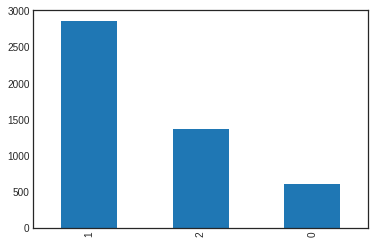

In [10]:
total_data['labels'].value_counts().plot(kind='bar')
label_count = total_data.groupby('labels').size().reset_index(name='count')
print(label_count)

In [11]:
# 데이터셋 분리 -> validation 도 나누어서 kfold 교차검증 할 예정
train_data, test_data = train_test_split(total_data, test_size=0.2, random_state=42)
print(len(train_data))
print(len(test_data))

3861
966


In [12]:
# 글자와 숫자만 남기고 제거 -> 영어랑 한국어 같이 있어도 되는지
train_data['kor_sentence'] = train_data['kor_sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9 ]", "")
print(len(train_data))
print(train_data[:10])

3861
      labels                                       kor_sentence
4123       1                        올리페카 칼라스부오가 이사회 부회장으로 선출되었다
2676       1  Savcor FACE를 Cencorp에 매각하면 받을 대가주 평가와 우세한 환율 등...
536        1  이번 청약으로 TGK10에 대한 포텀의 지분은 주식과 의결권의 76를 약간 넘는 수...
1909       1  패트릭 젬바는 또한 알스트롬의 혁신과 건강 안전 및 환경 HSEA 기능을 계속 담당...
189        2  지분율은 542에 비해 609로 2007년 3분기 냉동식품 사업의 순매출액은 총 1...
4628       1  4분기 말 현재 국내 통화 매출은 05퍼센트 감소한 반면 가입자 수는 1270만명 ...
4187       0  EB는 2008년 11월 18일 증권거래소에서 JT를 발표했다 베르크비스트는 EB ...
1751       2  헬싱키 톰슨 파이낸셜  코네는 사우디 아라비아 아랍에미리트 카타르에서 40mln 유...
280        2        사노마 매거진 핀란드의 순매출액은 1318 mn에서 1401 mn으로 증가했다
367        2                      핀란드의 매출은 39 증가했고 국제 성장률은 07였다


<ipython-input-12-15263384a632>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['kor_sentence'] = train_data['kor_sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9 ]", "")


In [13]:
test_data['kor_sentence'] = test_data['kor_sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9 ]", "")
print(len(test_data))
print(test_data[:10])

966
      labels                                       kor_sentence
590        2      YIT에 대한 고객들의 신뢰 증가는 아파트 매매가 가속화된 것으로 볼 수 있습니다
2179       2    생산은 2010년 동안 멕시코와 헝가리를 포함한 엘코텍의 다른 지역으로 확대될 것이다
917        2  바이살라는 또한 2009년의 2억5220만 유로에 비해 2010년에는 2억5320만...
1484       2   우리는 스마트폰 기능 모바일 인터넷 서비스 개발 그리고 두 가지를 매끄러운 사용자...
1702       1  핀란드의 배관 및 난방 시스템 공급 업체인 오노르는 2008년 8월 전사적인 비용 ...
2626       1  이커머스 사이트와 플래그십은 지난해 미국에 설립된 자회사 마리멕코 북미리테일 LLC...
1622       1  러시아 북서부 볼로그다 지역 셰크스나 지구에 대규모 목공시설을 2009년 착공해 2...
1029       1  케이블비전 시스템즈 매디슨 스퀘어 가든은 매디슨 스퀘어 가든 뉴욕 레인저스 하키팀 ...
4240       1                           신임 CEO가 선임될 때까지 선임은 유효하다
4063       0  10월 UPM은 2007년 1억2000만 유로에 비해 3분기 순손실이 1억1000만...


<ipython-input-13-27ca7cfbcc23>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['kor_sentence'] = test_data['kor_sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9 ]", "")


# 4. 토큰화, 불용어 처리

불용어 사전: '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게'

In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [15]:
mecab = Mecab()

train_data['kor_sentence'] = train_data['kor_sentence'].apply(mecab.morphs)
train_data['kor_sentence'] = train_data['kor_sentence'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['kor_sentence'] = test_data['kor_sentence'].apply(mecab.morphs)
test_data['kor_sentence'] = test_data['kor_sentence'].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
X_train = train_data['kor_sentence']
X_test = test_data['kor_sentence']
y_train = train_data['labels']
y_test = test_data['labels']

print(X_train[:2])
print(y_train[:2])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

4123             [올리, 페카, 칼라스, 부오, 사회, 부회장, 으로, 선출, 되, 었]
2676    [Savcor, FACE, Cencorp, 매각, 면, 받, 대, 가주, 평가, 우...
Name: kor_sentence, dtype: object
4123    1
2676    1
Name: labels, dtype: int64
(3861,)
(3861,)
(966,)
(966,)


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
word_counts = len(tokenizer.word_index) # 전체 단어 수

In [19]:
vocab_size = word_counts + 2
print(vocab_size)

9375


In [20]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [21]:
print(X_train[:3])
print(X_test[:3])

[[1086, 1355, 3088, 1537, 277, 1211, 9, 1538, 16, 22], [2429, 3089, 1739, 172, 92, 175, 189, 3090, 750, 4487, 1539, 138, 3091, 9, 576, 1540, 3092, 250, 14, 24, 328, 227, 4488, 28, 7], [120, 577, 9, 2013, 75, 55, 178, 1356, 124, 63, 578, 2430, 798, 860, 339, 9, 4489]]
[[485, 55, 88, 1995, 25, 1385, 3252, 8142, 169, 35, 7, 9, 654, 24, 4, 23], [68, 50, 2, 148, 1337, 2235, 70, 545, 195, 167, 130, 9, 490, 28, 7], [887, 659, 267, 150, 32, 2, 38, 53, 1, 13, 6, 114, 50, 2, 38, 53, 1, 13, 6, 48, 59, 28, 7, 9, 107, 471, 33]]


# 6. 패딩

In [22]:
print('문장 최대 길이 : ', max(len(l) for l in X_train))
print('문장 평균 길이 : ', sum(map(len, X_train)) / len(X_train))

문장 최대 길이 :  55
문장 평균 길이 :  18.656824656824657


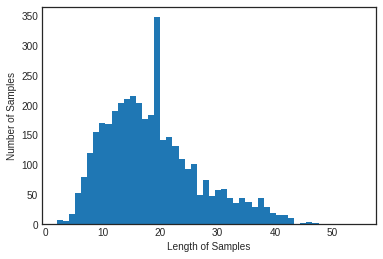

In [23]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [24]:
max_len = 45

# 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [26]:
print(X_train[:1])
print(X_test[:1])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 1086 1355 3088 1537  277 1211    9
  1538   16   22]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  485   55   88 1995   25 1385 3252 8142  169   35    7    9  654
    24    4   23]]


In [27]:
# softmax 적용을 해야해서 클래스를 나누어 주어야 함
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

# 7. 모델링 (LSTM) 

In [28]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [29]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128)) 
# model.add(BatchNormalization()) 
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu')) 
# model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_get_f1', mode='max', verbose=1, save_best_only=True)

In [30]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=[get_f1]) 

model.summary()
# recall, f1 등등 확인 -> 케라스 이용법 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         937500    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,063,199
Trainable params: 1,063,199
Non-

In [31]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 0.9458 - get_f1: 0.4044
Epoch 1: val_get_f1 improved from -inf to 0.62242, saving model to best_model.h5
52/52 [==============================] - 8s 19ms/step - loss: 0.9456 - get_f1: 0.4068 - val_loss: 0.8372 - val_get_f1: 0.6224
Epoch 2/100
45/52 [========================>.....] - ETA: 0s - loss: 0.7390 - get_f1: 0.6414
Epoch 2: val_get_f1 improved from 0.62242 to 0.68532, saving model to best_model.h5
52/52 [==============================] - 0s 9ms/step - loss: 0.7297 - get_f1: 0.6434 - val_loss: 0.6939 - val_get_f1: 0.6853
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 0.4394 - get_f1: 0.8239
Epoch 3: val_get_f1 improved from 0.68532 to 0.72741, saving model to best_model.h5
52/52 [==============================] - 0s 9ms/step - loss: 0.4428 - get_f1: 0.8245 - val_loss: 0.6626 - val_get_f1: 0.7274
Epoch 4/100
48/52 [==========================>...] - ETA: 0s - loss: 0.2029 - get_f1: 0.9359
Epo

In [32]:
# loaded_model = load_model('best_model.h5')
model.evaluate(X_test, y_test)

31/31 [==============================] - 0s 4ms/step - loss: 2.0457 - get_f1: 0.7131


[2.0456860065460205, 0.7130535244941711]

In [33]:
# K-Fold Cross Validation

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

# 아래 부분에서 kfold가 아니라면 for문이 돌아갈필요가 없을것이다.

for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model_k = Sequential()
  model_k.add(Embedding(vocab_size, 100))
  model_k.add(LSTM(128)) 
  model_k.add(Dropout(0.5))
  model_k.add(Dense(64, activation = 'relu')) # 함수형 api 공부
  model_k.add(Dropout(0.5))
  model_k.add(Dense(3, activation = 'softmax'))

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
  mc = ModelCheckpoint('best_model.h5', monitor='val_get_f1', mode='max', verbose=1, save_best_only=True)

  # Compile the model
  model_k.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=[get_f1]) # recall, f1 등등 확인 -> 케라스 이용법 확인

  #model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_k.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)

  scores = model_k.evaluate(X_test, y_test)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
49/52 [===========================>..] - ETA: 0s - loss: 0.9643 - get_f1: 0.3703
Epoch 1: val_get_f1 improved from -inf to 0.60514, saving model to best_model.h5
52/52 [==============================] - 3s 19ms/step - loss: 0.9574 - get_f1: 0.3839 - val_loss: 0.8777 - val_get_f1: 0.6051
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 0.7468 - get_f1: 0.6313
Epoch 2: val_get_f1 improved from 0.60514 to 0.65662, saving model to best_model.h5
52/52 [==============================] - 1s 10ms/step - loss: 0.7379 - get_f1: 0.6407 - val_loss: 0.7086 - val_get_f1: 0.6566
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.4867 - get_f1: 0.7851
Epoch 3: val_get_f1 improved from 0.65662 to 0.69501, saving model to best_model.h5
52/52 [==============================] - 1s 16ms/step - loss: 0.4878 - get_f1: 0.7856 - val_loss: 0.7328 - val_get_f1: 0.69

In [34]:
def sentiment_pred(new_sentence) :
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen = max_len)
    #print(new_pad)
    score = model.predict(new_pad)
    #print(score)
    #print(np.argmax(score))
    max_score = score[0][np.argmax(score)]

    if np.argmax(score) == 0 :
        print(f'기사 제목 : {new_sentence} -> 부정({(max_score*100):.2f}%)')
    elif np.argmax(score) == 1 :
        print(f'기사 제목 : {new_sentence} -> 중립({(max_score*100):.2f}%)')
    else :
        print(f'기사 제목 : {new_sentence} -> 긍정({(max_score*100):.2f}%)')

In [43]:
sentiment_pred('이번주 방향성 없는 코스피…시장은 재차 숨고르기')
sentiment_pred('올해 마지막 FOMC 앞두고 블랙아웃 진입…피봇 기대감 여전')
sentiment_pred('올해 삼성전자 임원 자사주 121억원 매입…주가부양 노력')
sentiment_pred('세일즈포스, 3분기 실적 컨센 상회…계약 반등 시점은 불확실')

1/1 [==============================] - 0s 17ms/step
기사 제목 : 이번주 방향성 없는 코스피…시장은 재차 숨고르기 -> 중립(97.23%)
1/1 [==============================] - 0s 15ms/step
기사 제목 : 올해 마지막 FOMC 앞두고 블랙아웃 진입…피봇 기대감 여전 -> 중립(97.80%)
1/1 [==============================] - 0s 15ms/step
기사 제목 : 올해 삼성전자 임원 자사주 121억원 매입…주가부양 노력 -> 긍정(100.00%)
1/1 [==============================] - 0s 15ms/step
기사 제목 : 세일즈포스, 3분기 실적 컨센 상회…계약 반등 시점은 불확실 -> 부정(87.30%)
